In [65]:
import time
import os
from collections import deque
import cv2
import tensorflow as tf
import random

# environment manipulation
from pathlib import Path


# ml libraries
import numpy as np
import pandas as pd

import brainflow
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations


# from keras.models import Model
# from keras.layers import Input
# from keras.layers import Dense

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
# import a numpy from the environment
stored_data = np.loadtxt('../FullData/Forward/1631924139.npy', delimiter=",")

In [67]:
stored_data

array([[ 1.00000000e+00, -1.66667124e+04, -9.31278727e+03, ...,
         0.00000000e+00,  1.63192414e+09,  0.00000000e+00],
       [ 2.00000000e+00, -1.64634903e+04, -9.19910630e+03, ...,
         0.00000000e+00,  1.63192414e+09,  0.00000000e+00],
       [ 3.00000000e+00, -1.65431743e+04, -9.22568252e+03, ...,
         0.00000000e+00,  1.63192414e+09,  0.00000000e+00],
       ...,
       [ 1.86000000e+02, -1.65002813e+04, -9.24148521e+03, ...,
         0.00000000e+00,  1.63192414e+09,  0.00000000e+00],
       [ 1.87000000e+02, -1.64916088e+04, -9.23784187e+03, ...,
         0.00000000e+00,  1.63192414e+09,  0.00000000e+00],
       [ 1.88000000e+02, -1.67013352e+04, -9.35027115e+03, ...,
         0.00000000e+00,  1.63192414e+09,  0.00000000e+00]])

In [68]:
homemade_columns = []
for i in range(1, 25):
    num = "c" + str(i)
    homemade_columns.append(num)
    
print (homemade_columns)
    

['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24']


In [69]:
# put it in a dataframe
data = pd.DataFrame(stored_data, columns=homemade_columns)

In [70]:
data.head()


,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24
0,1.0,-16666.712364,-9312.787272,-111083.856056,-121721.811202,-89987.407921,-40370.782062,-68390.504228,-24590.673994,0.07,...,48.0,25.0,208.0,16.0,208.0,0.0,0.0,0.0,1.631924e+09,0.0
1,2.0,-16463.490303,-9199.106300,-113415.835907,-121520.444336,-93501.102150,-45480.703769,-70203.230703,-26671.062609,0.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.631924e+09,0.0
2,3.0,-16543.174272,-9225.682524,-112519.150975,-121375.940308,-93559.976645,-45572.569439,-69522.396567,-26500.831723,0.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.631924e+09,0.0
3,4.0,-16751.716048,-9333.216767,-110061.375506,-121560.453959,-90089.577745,-40442.978196,-67623.191193,-24393.442201,0.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.631924e+09,0.0
4,5.0,-16703.212762,-9322.845557,-110646.566528,-121732.294170,-89542.228227,-39774.951610,-68067.298003,-24316.105165,0.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.631924e+09,0.0


In [71]:
# Examplar heat map on a nonsense dataset
nonsense_2d = np.linspace(1, 5, 12).reshape(4, 3) 

print(nonsense_2d)

[[1.         1.36363636 1.72727273]
 [2.09090909 2.45454545 2.81818182]
 [3.18181818 3.54545455 3.90909091]
 [4.27272727 4.63636364 5.        ]]


<AxesSubplot:>

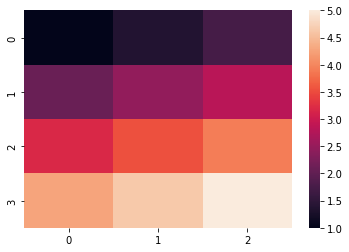

In [72]:
sns.heatmap(nonsense_2d)

In [73]:
# Using EEG signals now:
indexed_data = data.set_index('c1') # <--- make c1 index
indexed_data = data.drop([0.0])     # <--- drop first row, it's all zero's anyway
indexed_data.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24
1,2.0,-16463.490303,-9199.106300,-113415.835907,-121520.444336,-93501.102150,-45480.703769,-70203.230703,-26671.062609,0.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.631924e+09,0.0
2,3.0,-16543.174272,-9225.682524,-112519.150975,-121375.940308,-93559.976645,-45572.569439,-69522.396567,-26500.831723,0.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.631924e+09,0.0
3,4.0,-16751.716048,-9333.216767,-110061.375506,-121560.453959,-90089.577745,-40442.978196,-67623.191193,-24393.442201,0.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.631924e+09,0.0
4,5.0,-16703.212762,-9322.845557,-110646.566528,-121732.294170,-89542.228227,-39774.951610,-68067.298003,-24316.105165,0.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.631924e+09,0.0
5,6.0,-16479.985890,-9208.561088,-113169.542035,-121563.314982,-92998.880803,-44739.765792,-70008.390547,-26385.474370,0.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.631924e+09,0.0


In [74]:
# remove none EEG data
indexed_key_data = data.drop(columns=['c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24'])

indexed_key_data.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,1.0,-16666.712364,-9312.787272,-111083.856056,-121721.811202,-89987.407921,-40370.782062,-68390.504228,-24590.673994
1,2.0,-16463.490303,-9199.106300,-113415.835907,-121520.444336,-93501.102150,-45480.703769,-70203.230703,-26671.062609
2,3.0,-16543.174272,-9225.682524,-112519.150975,-121375.940308,-93559.976645,-45572.569439,-69522.396567,-26500.831723
3,4.0,-16751.716048,-9333.216767,-110061.375506,-121560.453959,-90089.577745,-40442.978196,-67623.191193,-24393.442201
4,5.0,-16703.212762,-9322.845557,-110646.566528,-121732.294170,-89542.228227,-39774.951610,-68067.298003,-24316.105165


<AxesSubplot:>

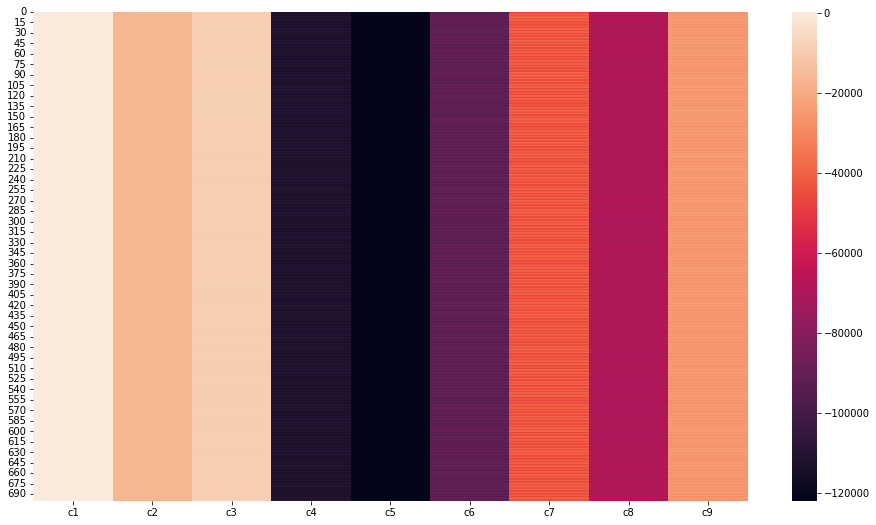

In [75]:
# create heatmap
plt.figure(figsize=(16, 9))
sns.heatmap(indexed_key_data)

## Scaling (but it's exactly the same).

In [76]:
scaled_data = tf.keras.utils.normalize(stored_data, axis=-1) 

In [77]:
scaled_data = pd.DataFrame(scaled_data, columns=homemade_columns)

In [78]:
scaled_data.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24
0,6.127736e-10,-0.00001,-0.000006,-0.000068,-0.000075,-0.000055,-0.000025,-0.000042,-0.000015,4.289415e-11,...,2.941313e-08,1.531934e-08,1.274569e-07,9.804377e-09,1.274569e-07,0.0,0.0,0.0,1.0,0.0
1,1.225547e-09,-0.00001,-0.000006,-0.000069,-0.000074,-0.000057,-0.000028,-0.000043,-0.000016,4.289415e-11,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,1.0,0.0
2,1.838321e-09,-0.00001,-0.000006,-0.000069,-0.000074,-0.000057,-0.000028,-0.000043,-0.000016,4.289415e-11,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,1.0,0.0
3,2.451094e-09,-0.00001,-0.000006,-0.000067,-0.000074,-0.000055,-0.000025,-0.000041,-0.000015,4.289415e-11,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,1.0,0.0
4,3.063868e-09,-0.00001,-0.000006,-0.000068,-0.000075,-0.000055,-0.000024,-0.000042,-0.000015,4.289415e-11,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,1.0,0.0


In [79]:
# Using EEG signals now:
scaled_indexed_data = scaled_data.set_index('c1') # <--- make c1 index
scaled_indexed_data = scaled_data.drop([0.0])     # <--- drop first row, it's all zero's anyway
# remove none EEG data
scaled_indexed_key_data = scaled_data.drop(columns=['c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24'])
scaled_indexed_key_data.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,6.127736e-10,-0.00001,-0.000006,-0.000068,-0.000075,-0.000055,-0.000025,-0.000042,-0.000015
1,1.225547e-09,-0.00001,-0.000006,-0.000069,-0.000074,-0.000057,-0.000028,-0.000043,-0.000016
2,1.838321e-09,-0.00001,-0.000006,-0.000069,-0.000074,-0.000057,-0.000028,-0.000043,-0.000016
3,2.451094e-09,-0.00001,-0.000006,-0.000067,-0.000074,-0.000055,-0.000025,-0.000041,-0.000015
4,3.063868e-09,-0.00001,-0.000006,-0.000068,-0.000075,-0.000055,-0.000024,-0.000042,-0.000015


<AxesSubplot:>

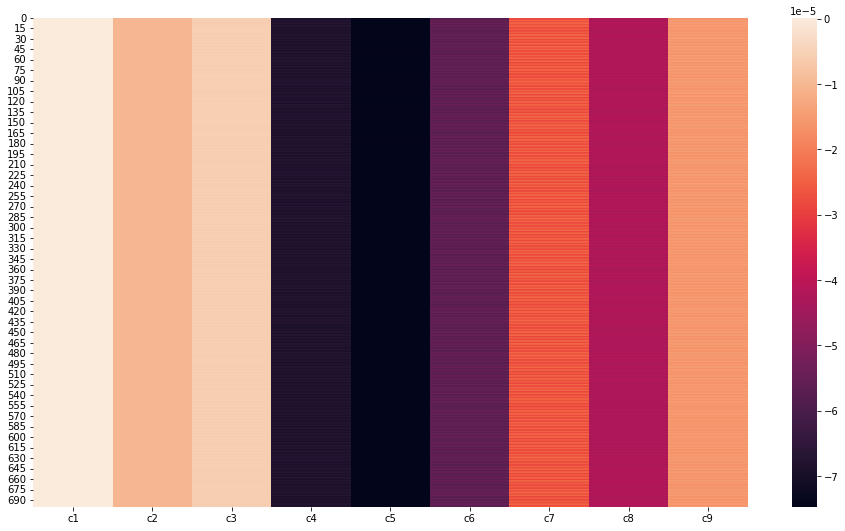

In [80]:
# create heatmap
plt.figure(figsize=(16, 9))
sns.heatmap(scaled_indexed_key_data)

## Scaling MinMaxScaler() ...

In [81]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_indexed_key_data = scaler.fit_transform(np.array(indexed_key_data))
scaled_indexed_key_data = pd.DataFrame(scaled_indexed_key_data, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8'])
scaled_indexed_key_data.drop(columns=['c0'], inplace=True)

scaled_indexed_key_data.head()

,c1,c2,c3,c4,c5,c6,c7,c8
0,0.376425,0.364017,0.668223,0.349449,0.826472,0.832750,0.720871,0.817591
1,0.827104,0.724982,0.068161,0.728201,0.158224,0.167552,0.242958,0.227534
2,0.650392,0.640596,0.298895,1.000000,0.147027,0.155593,0.422455,0.275816
3,0.187915,0.299148,0.931327,0.652947,0.807041,0.823352,0.923168,0.873532
4,0.295479,0.332079,0.780746,0.329732,0.911138,0.910314,0.806083,0.895467


<AxesSubplot:>

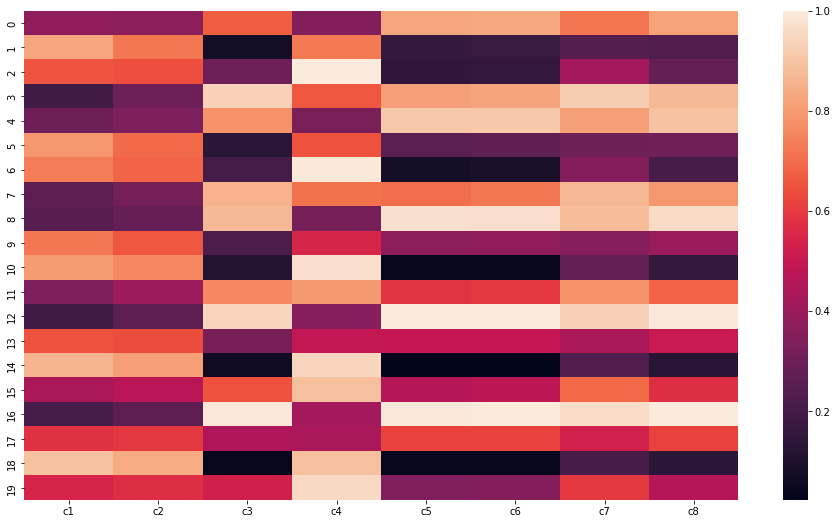

In [82]:
# create heatmap
plt.figure(figsize=(16, 9))
sns.heatmap(scaled_indexed_key_data.head(20))